In [ ]:
import numpy as np 
import pandas as pd
import simpy
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns 

np.random.seed(40)

In [ ]:
def partition(number):
    ## number로 나눌 수 있는 모든 파티션 종류를 리턴
    answer = set() ## 일단 현재 number도 partition 중 하나 이므로 tuple로 넘겨주고 
    answer.add((number, )) 
    for x in range(1, number):## binary partition: increase x and partition y 
        for y in partition(number - x):## new partition of x 
            answer.add(tuple(sorted((x, ) + y)))## like this
    return answer

def list_partition(input_lst, split_size):
    if sum(split_size)==len(input_lst):
        r_lst = [input_lst[sum(split_size[:i-1]):sum(split_size[:i])] for i in range(1, len(split_size)+1)]
        return r_lst
    else:
        print('sum(split_size)!=len(input_lst)')
        return None

def make_random_tree(node_set, level=3):
    ## node set으로부터 random하게 tree를 만듬 
    rG = nx.Graph()    
    ps = [p for p in partition(len(node_set)-1) if len(p)==level-1]## 각 레벨별로 몇 명의 node가 있을지 정하고 
    selected_p = ps[np.random.randint(0, len(ps))]
    rG.add_node('l0_u1', level=0) ## 탑노드 
    for level, children_size in enumerate(selected_p):
        level = level+1
        parent_node_set = [ n[0] for n in rG.node(data=True) if n[1]['level'] == level-1]
        children_node_set = [('l{}_u{}'.format(level, i), {'level':level}) for i in range(0, children_size)]
        rG.add_nodes_from(children_node_set)
        ## children_node_set을 parent_node_set에 맞춰 나누어야 함 
        children_ps = [p for p in partition(len(children_node_set)) if len(p)==len(parent_node_set)]
        children_ps = children_ps[np.random.randint(0, len(children_ps))]
        children_ps = list_partition(children_node_set, children_ps)
        for j, par_n in enumerate(parent_node_set):
            rG.add_star([par_n]+[ c[0] for c in children_ps[j]])
    ## relabel 
    new_node_label = np.random.choice(node_set, len(node_set), replace=False)
    return nx.relabel_nodes(rG, {n: new_n for n, new_n in zip(rG.nodes(), new_node_label)})

def tree_position(inputG):
    ## tree 구조인 graph의 포지션을 만들어줌
    pos_dict = {}
    levels = {n[1]['level'] for n in inputG.nodes(data=True)}
    for i, l in enumerate(range(min(levels), max(levels)+1)):
        nodes = [n for n in inputG.nodes(data=True) if n[1]['level']==l]
        y = 1.0 - (1.0/(len(levels)+1)*(i+1))
        pos_dict.update({n[0]:(1.0/(len(nodes)+1)*(j+1), y) for j, n in enumerate(nodes)})
    return pos_dict

In [3]:
def bipartite_layout(inputG, LR=True):
    ## bipartite한 graph의 layout
    if nx.is_bipartite(inputG) and nx.is_connected(inputG):## connected and bipartite
        bs1, bs2 = nx.bipartite.sets(inputG)
        bs1 = sorted(bs1, key=lambda x: x.name, reverse=True)
        bs2 = sorted(bs2, key=lambda x: x.name, reverse=True)
        pos = {}
        if LR==True:
            pos.update({n:(0, 1.0/(len(bs1)+1)*(i+1)) for i, n in enumerate(bs1)})
            pos.update({n:(1, 1.0/(len(bs2)+1)*(i+1)) for i, n in enumerate(bs2)})
        else:
            pos.update({n:(1.0 - 1.0/(len(bs1)+1)*(i+1), 1) for i, n in enumerate(bs1)})
            pos.update({n:(1.0 - 1.0/(len(bs2)+1)*(i+1), 0) for i, n in enumerate(bs2)})
        return pos
    else:# 이 경우 none을 리턴하므로, default layout으로 그림이 그려지게 됩니다. 
        print("it is not bipartite and not connected")

def make_deg_seq(deg_sum, seq_a_len, max_deg):
    ## deg_sum에 맞도록 degree dist를 랜덤하게 분포함
    ## max_deg는 한 node가 가질 수 있는 최대 degree, 여기서는 multi graph가 아닌 graph로 가정 
    ## partition을 이용해서 만드는 방법도 해봤지만, 속도 문제가 너무 큼, 당연한것이 아래는 단 하나의 조건만을 만드는 경우, 
    ## partition을 이용하면, 모든 종류를 다 만드는 경우 
    if deg_sum > (seq_a_len*max_deg):
        print("deg_sum is too large")
    elif deg_sum < seq_a_len or deg_sum < max_deg:
        print("deg_sum is too small")
    else: 
        seq_a = [1 for i in range(0, seq_a_len)]
        remain_seq_a = deg_sum - seq_a_len
        while remain_seq_a>0:
            idx = np.random.choice(seq_a_len)
            if seq_a[idx]+1<=max_deg:
                seq_a[idx]+=1
                remain_seq_a-=1
        return seq_a

In [8]:
## resource와 activity를 bipartite한 네트워크로 구성하고, 
## activity를 수행해야 할 때는 일단 해당 activity를 수행할 수 있는 사람셋을 해당 네트워크를 통해서 찾음 
## 액티비티 종료 후 
#act_resource_network = nx.Graph()
class Activity(object):
    def __init__(self, name, t_dist=(1,3,5)):
        self.name = name
        self.t_dist = t_dist# (min, max, mode)
    def __repr__(self):
        return self.name
    
class Resource(object):
    def __init__(self, name, t_dist=(1,3,5)):
        self.name = name
        self.t_dist = t_dist
    def __repr__(self):
        return self.name


##### setting
## 여기서 각 A_set와 R_set를 만들어 준다. 
A_set = [Activity('A{:0>2d}'.format(i), (1, 3, 5)) for i in range(0, 5)]
R_set = [Resource('R{:0>2d}'.format(i), (1, 2, 1.5)) for i in range(0, 20)]
#########################
deg_sum = len(R_set)*len(A_set)*0.4//1.0
R_A_net = nx.bipartite.havel_hakimi_graph(make_deg_seq(deg_sum, len(R_set), len(A_set)), 
                                          make_deg_seq(deg_sum, len(A_set), len(R_set))
                                         )

## update type attribute
mapping = {}
for i, n in enumerate([n[0] for n in R_A_net.nodes(data=True) if n[1]['bipartite']==0]):
    R_A_net.nodes[n]['type']='Resource' ## for relabeling 
    mapping[n] = R_set[i]
for i, n in enumerate([n[0] for n in R_A_net.nodes(data=True) if n[1]['bipartite']==1]):
    R_A_net.nodes[n]['type']='Activity'
    mapping[n] = A_set[i]
R_A_net = nx.relabel_nodes(R_A_net, mapping)
R_net = make_random_tree(R_set, 5)
###############

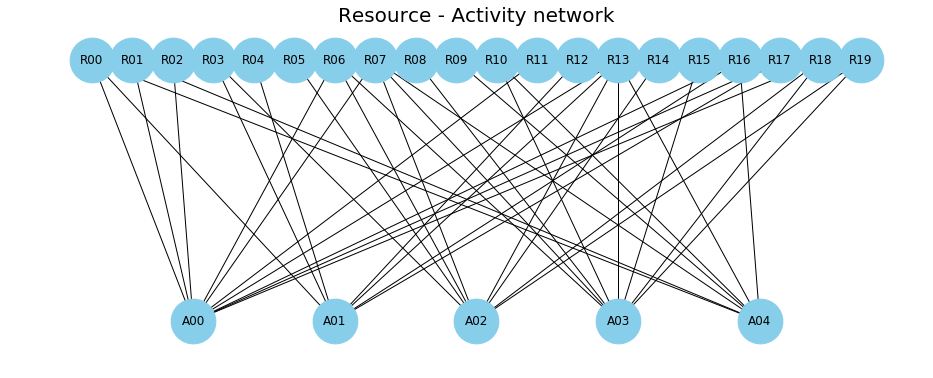

In [10]:
plt.figure(figsize=(16, 6))
nx.draw_networkx(R_A_net, pos=bipartite_layout(R_A_net, LR=False), node_size=2000, node_color='skyblue')

#nx.draw_networkx(R_net, pos=tree_position(R_net), node_size=2000, node_color='skyblue', ax = axes[1])
plt.axis('off')
plt.title('Resource - Activity network', fontsize=20)
#axes[1].set_title('Resource Network', fontsize=20)
plt.show()

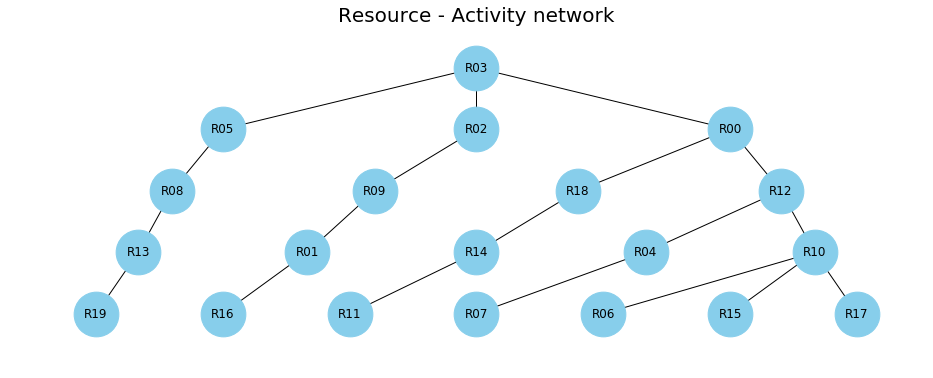

In [11]:
plt.figure(figsize=(16, 6))
nx.draw_networkx(R_net, pos=tree_position(R_net), node_size=2000, node_color='skyblue')
plt.axis('off')
plt.title('Resource - Activity network', fontsize=20)
#axes[1].set_title('Resource Network', fontsize=20)
plt.show()

In [12]:
log_df = [] ## log 
def process(env, process_name, activity_lst, human_store):
    ## print('<{}> start                at {:8.2f}'.format(process_name, env.now))
    ## process의 activity를 수행할 리소스 조합을 찾음
    resource_lst = [np.random.choice(list(R_A_net.neighbors(act))) for act in activity_lst]
    for i, act_r in enumerate(zip(activity_lst, resource_lst)):
        act, r = act_r
        left, mode, right = act.t_dist 
        human = yield human_store.get(lambda x: True if x is r else False )
        ## (process_name, activity_name, resource, start or end, timestamp)
        log_df.append( (process_name, act.name, human.name, 'start', env.now) )
        ## print("<{}> {} start by {}     at {:6.2f}".format(process_name, act.name, human, env.now))
        execution_time = np.random.triangular(left=left, right=right, mode=mode)
        yield env.timeout(execution_time)
        yield human_store.put(human)
        ## print("<{}> {}   end by {}     at {:6.2f}".format(process_name, act.name, human, env.now))
        log_df.append( (process_name, act.name, human.name, 'end', env.now) )
        ## 여기서는 transfer of work이 있으므로 일을 조직구조에 따라서 일을 전달함. 
        if (i+1) < len(resource_lst) and r != resource_lst[i+1]:## 마지막 activity가 아닐 때만 다음 resource를 찾아줌 
                resource_path = nx.shortest_path(R_net, r, resource_lst[i+1])
                ## print("<{}> transfer start:      at {:6.2f}".format(process_name, env.now))
                for i in range(0, len(resource_path[1:-1])):
                    ## edge time 
                    ## print("<{}> transfer {} => {}  at {:6.2f}".format(process_name, resource_path[i], resource_path[i+1], env.now))
                    yield env.timeout(np.random.triangular(1, 2, 3)) 
                    ## print('<{}> {} execute transfer at {:6.2f}'.format(process_name, resource_path[i+1], env.now))
                    ## node time
                    tranfer_h = yield human_store.get(lambda x: True if x is r else False )
                    yield env.timeout(np.random.triangular(1, 2, 3)) ## node time 
                    yield human_store.put(tranfer_h)
                ## edge time
                ## print("<{}> transfer {} => {}  at {:6.2f}".format(process_name, resource_path[-2], resource_path[-1], env.now))
                yield env.timeout(np.random.triangular(1, 2, 3))
                #print("transfer {} => {}".format())
                ## print("<{}> transfer end         at {:6.2f}".format(process_name, env.now))
    ## print('<{}> end                  at {:8.2f}'.format(process_name, env.now))
    return None

def process_generator(env, activity_set, resource_set, process_size):
    ## 주기적으로 process 를 env에 등록함 
    human_store = simpy.FilterStore(env)
    human_store.items = [r for r in resource_set]
    for i in range(0, process_size):
        yield env.timeout(np.random.triangular(1, 3, 5))
        ## 만약 activity-set에 약간 랜덤성을 부여하고 싶을 경우, 여기서 activity-set를 알아서 조절해서 넘김 
        ## 예를 들어서, exclusive하게 process 의 activity 조합이 만들어진 경우에는 활률적으로 activity를 조절하여 넘김 
        env.process(
            process(env=env, 
                    process_name = 'Process{:0>2d}'.format(i), 
                    activity_lst = activity_set, human_store = human_store)
        )
        
###########
env = simpy.Environment()

env.process(process_generator(env, A_set, R_set, process_size=200))
env.run()
print('complete')

complete


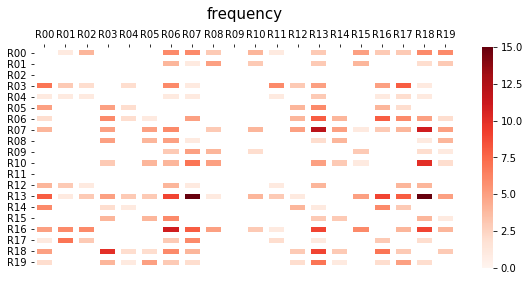

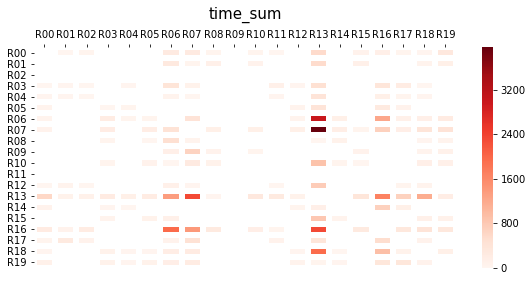

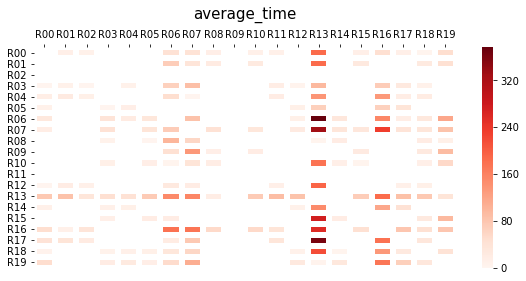

In [64]:
"""
- heatmap을 그려줌 
- resource간의 transfer할때 발생하는 bottleneck를 표현해줌
"""
df = pd.DataFrame(log_df, columns = ['process', 'activity', 'resource', 'start_end', 'timestamp'])
r_columns = sorted(set(df['resource']))
R_R_matrix = {
    'frequency': pd.DataFrame(np.zeros((len(r_columns), len(r_columns))), columns = r_columns, index=r_columns), 
    'time_sum': pd.DataFrame(np.zeros((len(r_columns), len(r_columns))), columns = r_columns, index=r_columns)
}

for g in df.groupby('process'):
    sub_df = g[1].iloc()[1:-1]
    for i in range(0, len(sub_df), 2):
        from_series, to_series = sub_df.iloc()[i], sub_df.iloc()[i+1]
        if from_series.resource != to_series.resource:## 같을 때는 transfer of work이 아님.       
            R_R_matrix['frequency'][from_series.resource][to_series.resource] += 1
            R_R_matrix['time_sum'][from_series.resource][to_series.resource] += (to_series['timestamp'] - from_series['timestamp'])
R_R_matrix['average_time'] = (R_R_matrix['time_sum']/ R_R_matrix['frequency']).fillna(0)
## frequency heatmap 
for k in R_R_matrix.keys():
    plt.figure(figsize=(8, 4))
    sns.heatmap(R_R_matrix[k], cmap=plt.cm.Reds, 
                mask = R_R_matrix[k].applymap(lambda x: False if x!=0 else True), 
                linewidths=5, cbar=True, square=False)
    plt.tick_params(labelsize=10)
    #title_pos = sum(plt.xlim())/2, plt.ylim()[0]
    plt.title(k, position=(0.5, 1+0.1), fontsize=15)## title 위치 변경 
    plt.gca().xaxis.tick_top(), plt.xticks(rotation=0), plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [14]:
## activity 별로 일하는데 소요되는 시간을 쭉 뽑아서 time dist를 추정할 수 있지 않을까? 
## normal, exp, tri 중 무엇으로 할지는 봐야 할듯 
## each activity의 min, mode, max를 찾기 
activity_duration_dict = {k:[] for k in set(df['activity'])}
for g in df.groupby(['process', 'activity']):
    act_key = g[0][1]# g[0] ==> (process, activity)
    activity_duration_dict[act_key].append(g[1]['timestamp'].iloc()[1] - g[1]['timestamp'].iloc()[0])

In [15]:
def find_mode(input_lst):
    ma, mi = max(input_lst), min(input_lst)
    bin_size = np.round(1+3.322*np.log10(len(input_lst)))## 최적의 binsize를 찾는 계산법 
    r_lst = ((x-mi)/(ma-mi) for x in input_lst)
    r_lst = (x//(1/(bin_size))/(bin_size) for x in r_lst)
    r_dict = {} ## collection Counter를 쓸 수도 있지만, 없이 하는게 더 의존성을 줄이고 좋을 것 같았음
    for k in (x*(ma-mi)+mi for x in r_lst):
        r_dict[k] = r_dict[k]+1 if k in r_dict.keys() else 1
    return sorted(r_dict.items(), key=lambda x: x[1], reverse=True)[0][0]

for k, v in activity_duration_dict.items():
    print(k)
    print(min(v), max(v), find_mode(v))

A04
1.12942259947 4.82398258705 2.77144926062
A03
1.18973751711 4.75359030176 2.77367208807
A02
1.20890864026 4.8002428085 2.80505715948
A01
1.21510830468 4.61377118978 3.10325435196
A00
1.26629037241 4.80761577845 2.8402127751


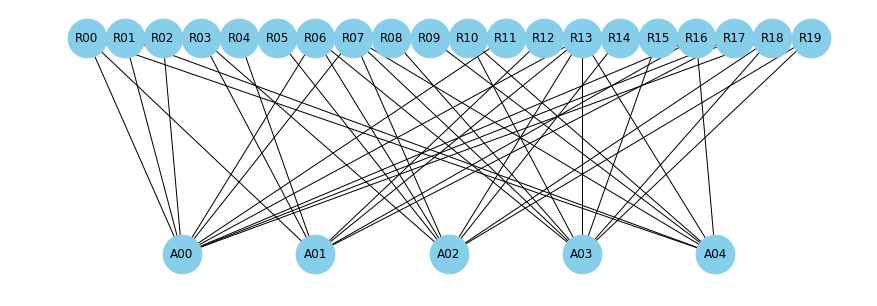

((-0.023068758974054505,
  1.0230687589740544,
  -0.12837162768263718,
  1.1283716276826374),
 None)

In [63]:
## log로부터 R_A_net을 만듭니다. 
def make_R_A_net_from_log(inputdf):
    rG = nx.Graph()
    edges = set((tuple(v) for v in df[['activity', 'resource']].values))
    ## 여기서 activity를 넣을대, t_dist를 넣어서 돌려주면 더 좋을 것 같은데. 
    As = {e[0]:Activity(e[0]) for e in edges} ## t-dist default
    Rs = {e[1]:Resource(e[1]) for e in edges} ## t-dist default
    rG.add_nodes_from( ( (Rs[k], {'type':'resource'}) for k in Rs.keys()) )
    rG.add_nodes_from( ( (As[k], {'type':'activity'}) for k in As.keys()) )
    rG.add_edges_from( ( (As[e[0]], Rs[e[1]]) for e in edges ) )
    return rG
ssss = make_R_A_net_from_log(df)
#print(ssss.nodes(data=True))
plt.figure(figsize=(15, 5))
nx.draw_networkx(ssss, pos = bipartite_layout(ssss, LR=False), node_size=1500, node_color='skyblue')
plt.axis('off'), plt.show()

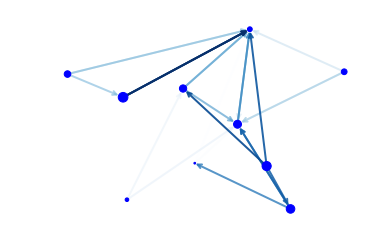

In [67]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.generators.directed.random_k_out_graph(10, 3, 0.5)
pos = nx.layout.spring_layout(G)

node_sizes = [3 + 10 * i for i in range(len(G))]
M = G.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='blue')
edges = nx.draw_networkx_edges(G, pos, node_size=node_sizes, arrowstyle='->',
                               arrowsize=10, edge_color=edge_colors,
                               edge_cmap=plt.cm.Blues, width=2)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

ax = plt.gca()
ax.set_axis_off()
plt.show()

(-0.084000000000000019,
 0.88400000000000012,
 0.46229343305050036,
 0.53770656694949981)

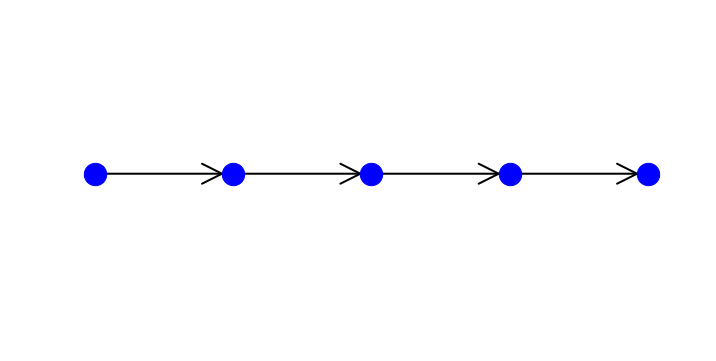

In [85]:
##
import networkx as nx 
import matplotlib.pyplot as plt

DG = nx.DiGraph()
DG.add_nodes_from([ ("A{:0>2d}".format(i)) for i in range(0, 5)] )
DG.add_edges_from([ ("A{:0>2d}".format(i), "A{:0>2d}".format(i+1)) for i in range(0, 4) ] )
pos = { n: (1.0/len(DG.nodes())*i, 0.5) for i, n in enumerate(DG.nodes())}
plt.figure(figsize=(12, 6))
nx.draw_networkx_nodes(DG, pos=pos, node_size=500, node_color='blue')
nx.draw_networkx_edges(DG, pos=pos, edge_cmap=plt.cm.Blues, width=2, 
                       arrowstyle='->', arrowsize=50, )
plt.axis('off')

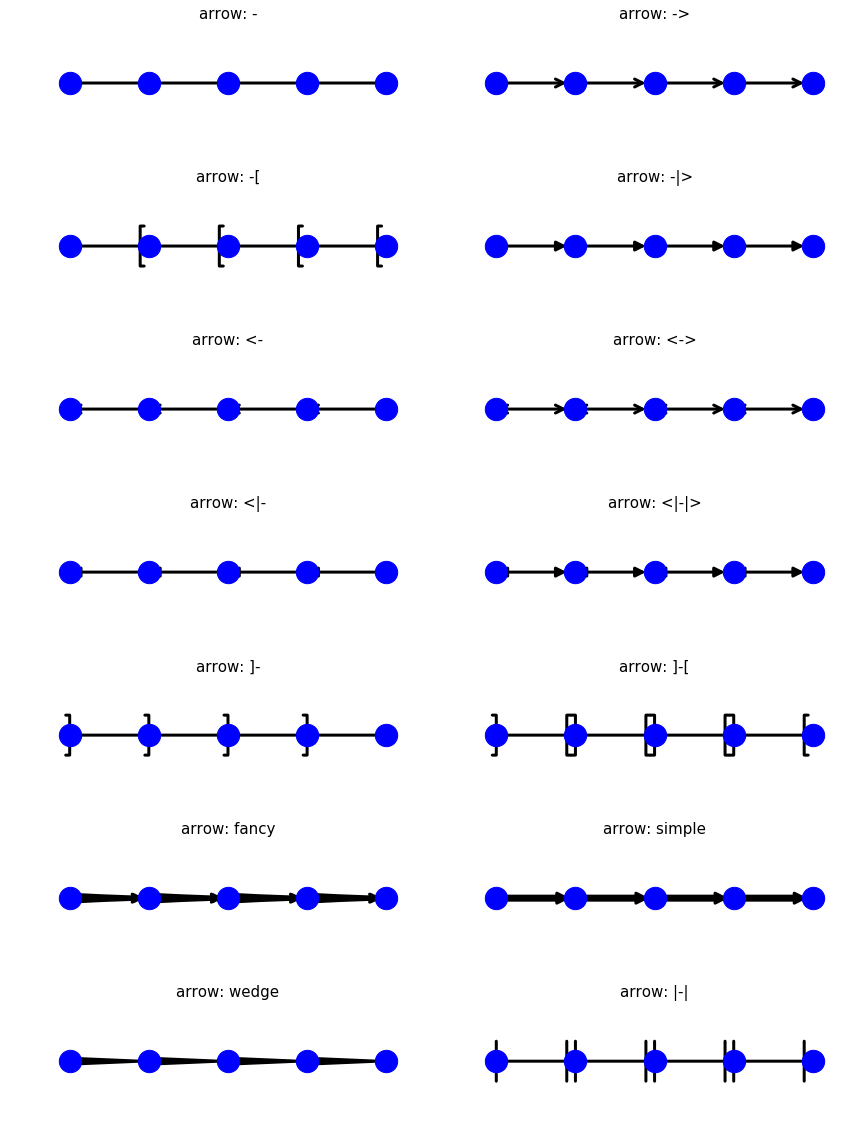

In [143]:
## https://matplotlib.org/api/_as_gen/matplotlib.patches.ArrowStyle.html
arrow_style_lst = ['-', '->', '-[', '-|>', '<-', '<->', '<|-',
                   '<|-|>', ']-', ']-[', 'fancy', 'simple', 'wedge', '|-|']
f, axes = plt.subplots(7, 2)
f.set_size_inches((12, 16))
for i, arrow_style in enumerate(arrow_style_lst):
    ax = axes[i//2][i%2]
    DG = nx.DiGraph()
    DG.add_nodes_from([ ("A{:0>2d}".format(i)) for i in range(0, 5)])
    DG.add_edges_from([ ("A{:0>2d}".format(i), "A{:0>2d}".format(i+1)) for i in range(0, 4) ] )
    pos = { n: (1.0/len(DG.nodes())*i, 0.5) for i, n in enumerate(DG.nodes())}
    nx.draw_networkx_nodes(DG, pos=pos, node_size=500, node_color='blue', ax=ax)
    nx.draw_networkx_edges(DG, pos=pos, width=3, 
                           arrowstyle=arrow_style, arrowsize=20, ax=ax)
    ax.set_title('arrow: {}'.format(arrow_style_lst[i]), fontsize=15), 
    ax.set_axis_off()
plt.tight_layout()
plt.savefig('../../assets/images/markdown_img/180813_arrow_style_comp.svg')
plt.show()

In [ ]:
## 

import seaborn as sns 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

temp_df = pd.DataFrame(np.random.normal(0, 1, (10, 10)), 
                       columns= ["col{}".format(i) for i in range(0, 10)], 
                       index= ["idx{}".format(i) for i in range(0, 10)]
                      )
plt.figure(figsize=(8, 6))
sns.heatmap(temp_df, cmap=plt.cm.Reds, linewidths=10)
plt.tick_params(labelsize=13) 
plt.title(k, fontsize=15)## title 위치 변경 
plt.gca().xaxis.tick_top(), plt.xticks(rotation=0), plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../../assets/images/markdown_img/180813_plt_title.svg')
plt.show()

In [ ]:
temp_df = pd.DataFrame(np.random.normal(0, 1, (10, 10)), 
                       columns= ["col{}".format(i) for i in range(0, 10)], 
                       index= ["idx{}".format(i) for i in range(0, 10)]
                      )
plt.figure(figsize=(8, 6))
sns.heatmap(temp_df, cmap=plt.cm.Reds, linewidths=10)
plt.tick_params(labelsize=13) 
plt.title(k, 
          position=(0.5, 1.0+0.05), 
          fontsize=15)## title 위치 변경 
plt.gca().xaxis.tick_top(), plt.xticks(rotation=0), plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../../assets/images/markdown_img/180813_plt_better_title.svg')
plt.show()